In [1]:
from bg_atlasapi import show_atlases
show_atlases()
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
import numpy as np
import os
import json
import pandas as pd
from pathlib import Path
import shutil
import bpy, bmesh
import os
from mathutils import Matrix, Vector
import bg_space as bg

╭───────────────────────────────── Brainglobe Atlases ─────────────────────────────────╮
│                                                                           Latest     │
│  Name                              Downloaded  Updated  Local version    version     │
│  allen_human_500um                     ✔          ✔          0.1           0.1       │
│  allen_mouse_25um                      ✔          ✔          1.2           1.2       │
│  azba_zfish_4um                        ✔          ✔          1.1           1.1       │
│  kim_mouse_25um                        ✔          ✔          1.0           1.0       │
│  whs_sd_rat_39um                       ✔          ✔          1.1           1.1       │
│  example_mouse_100um                                                       1.2       │
│  allen_mouse_10um                                                          1.2       │
│  allen_mouse_50um                                                          1.2       │
│  allen_mouse_100um                                                         1.2       │
│  mpin_zfish_1um                                                            1.0       │
│  kim_mouse_10um                                                            1.0       │
│  kim_mouse_50um                                                            1.0       │
│  kim_mouse_100um                                                           1.0       │
│  osten_mouse_10um                                                          1.1       │
│  osten_mouse_25um                                                          1.1       │
│  osten_mouse_50um                                                          1.1       │
│  osten_mouse_100um                                                         1.1       │
│  allen_cord_20um                                                           1.0       │
│  perens_lsfm_mouse_20um                                                    1.0       │
│  admba_3d_e11_5_mouse_16um                                                 1.0       │
│  admba_3d_e13_5_mouse_16um                                                 1.0       │
│  admba_3d_e15_5_mouse_16um                                                 1.0       │
│  admba_3d_e18_5_mouse_16um                                                 1.0       │
│  admba_3d_p4_mouse_16.752um                                                1.0       │
│  admba_3d_p14_mouse_16.752um                                               1.0       │
│  admba_3d_p28_mouse_16.752um                                               1.0       │
│  admba_3d_p56_mouse_25um                                                   1.0       │
│  princeton_mouse_20um                                                      1.0       │
│  kim_dev_mouse_stp_10um                                                    1.1       │
│  kim_dev_mouse_idisco_10um                                                 1.1       │
│  kim_dev_mouse_mri_a0_10um                                                 1.1       │
│  kim_dev_mouse_mri_adc_10um                                                1.1       │
│  kim_dev_mouse_mri_dwi_10um                                                1.1       │
│  kim_dev_mouse_mri_fa_10um                                                 1.1       │
│  kim_dev_mouse_mri_mtr_10um                                                1.1       │
│  kim_dev_mouse_mri_t2_10um                                                 1.1       │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
def intermediate_meta(atlas_name):
    """Build the metadata file

    Parameters
    ----------
    atlas_name : string
        bg-atlas name
    """
    meta_file = os.path.join(PATH,atlas_name,"meta.json")

    with open(meta_file, 'w', encoding='utf-8') as f:
        json.dump(atlas.metadata, f, ensure_ascii=False, indent=4)

def intermediate_ref_image(atlas_name):
    """Build the intermediate reference image. Input is the bg-atlas reference image (float32) output is a flattened .bytes file.

    Parameters
    ----------
    atlas_name : string
        bg-atlas name
    """
    reference_file = os.path.join(PATH,atlas_name,"reference.bytes")

    atlas = BrainGlobeAtlas(atlas_name)
    reference = atlas.reference

    reference = reference.astype(np.float32)
    reference = reference / np.max(reference)

    if not isinstance(reference[0,0,0], np.float32):
        print("Warning: atlas has incorrect reference image format")

    reference.flatten().tofile(reference_file)

def intermediate_annot_image(atlas_name):
    """Build the intermediate annotation image. Input is the bg-atlas annotation image (uint32) output is a flattened .bytes file

    Parameters
    ----------
    atlas_name : string
        bg-atlas name
    """
    annotation_file = os.path.join(PATH,atlas_name,"annotation.bytes")

    if os.path.exists(annotation_file):
        return

    atlas = BrainGlobeAtlas(atlas_name)
    annotation = atlas.annotation

    if not isinstance(annotation[0,0,0], np.uintc):
        print("Warning: atlas has incorrect reference image format")

    annotation.flatten().tofile(annotation_file)

def intermediate_mesh_centers(atlas_name):
    """Build the intermediate mesh center CSV files"""
    
    def f3f(val):
        return f'{val:0.3f}'

    mesh_center_file = os.path.join(PATH, atlas_name, "mesh_centers.csv")

    if os.path.exists(mesh_center_file):
        return

    atlas = BrainGlobeAtlas(atlas_name)
    res = atlas.resolution
    root_name = "root"

    all_structures = atlas.get_structure_descendants(root_name)
    all_structures.insert(0,root_name)

    df = pd.DataFrame(columns=["structure_name","ap","ml","dv","ap-lh","ml-lh","dv-lh"])

    shape = atlas.metadata['shape']


    for i, structure in enumerate(all_structures):
        mask = atlas.get_structure_mask(atlas.structures[structure]["id"])
        mask_left = mask[:,:,0:int(mask.shape[2]/2)]
        # the mask is in both hemispheres, but we actually only want to calculate one side. We'll do the left side, so to calculate right
        # you have to do dimension_size - value on each dimension

        if not np.any(mask.flatten()) or not np.any(mask_left.flatten()):
            df.loc[i] = [structure, -1, -1, -1, -1, -1, -1]
        else:
            coords_full = np.mean(np.argwhere(mask), axis=0)
            coords_left = np.mean(np.argwhere(mask_left), axis=0)
            # coords are ap/dv/ml, so flip 1/2
            df.loc[i] = [structure, f3f(np.float32(coords_full[0]*res[0])), f3f(np.float32(coords_full[2]*res[2])),
                         f3f(np.float32(coords_full[1]*res[1])), f3f(np.float32(coords_left[0]*res[0])),
                         f3f(np.float32(coords_left[2]*res[2])), f3f(np.float32(coords_left[1]*res[1]))]

    df.to_csv(mesh_center_file, float_format='%0.3f', index=False)



def intermediate_structures(atlas_name):
    """Save the structure hierarchy data (this is a symlink to the brainglobe file)

    Parameters
    ----------
    atlas_name : string
        bg-atlas name
    """
    atlas = BrainGlobeAtlas(atlas_name)

    shutil.copyfile(os.path.join(atlas.root_dir, 'structures.json'),os.path.join(PATH,atlas_name,"structures.json"))

# Function to recalculate normals and save the object
def modifiers_normals_smooth(obj_file, normals, smoothing):
    # Import the .obj file
    bpy.ops.import_scene.obj(filepath=obj_file)

    # Select the imported object
    obj = bpy.context.selected_objects[0]

    # Switch to Edit Mode and recalculate normals
    bpy.context.view_layer.objects.active = obj
    bpy.ops.object.mode_set(mode='EDIT')

    # Apply the Smooth modifier with factor=1 and repeat=10
    if smoothing:
        bpy.ops.object.modifier_add(type='SMOOTH')
        smooth_modifier = obj.modifiers[-1]  # Get the last added modifier (assuming no other modifiers are added in between)
        smooth_modifier.factor = 1
        smooth_modifier.iterations = 5

    if normals:
        bpy.ops.mesh.normals_make_consistent(inside=False)

    bpy.ops.object.mode_set(mode='OBJECT')

    # Save the object with recalculated normals
    bpy.ops.export_scene.obj(filepath=obj_file, use_selection=True, use_normals=True, use_materials=False)

    # Unlink the imported object (remove it from the scene)
    bpy.data.objects.remove(obj)

def cleanup_folder(atlas_name):
    """Remove extra #L.obj #LL.obj and *.mat files

    Parameters
    ----------
    atlas_name : _type_
        _description_
    """
    def is_desired_filename(filename):
        return filename.endswith(".obj") and filename[0].isdigit() and not filename.endswith("L.obj") and not filename.endswith("LL.obj")

    atlas = BrainGlobeAtlas(atlas_name)

    folder = os.path.join(PATH, atlas_name,'meshes')

    # Get a list of all files in the folder
    all_files = os.listdir(folder)

    # Iterate through the files and delete those that don't match the pattern
    for filename in all_files:
        if not is_desired_filename(filename):
            file_to_delete = os.path.join(folder, filename)
            os.remove(file_to_delete)

def apply_blender_repairs(atlas_name, normals = True, smoothing = False):
    """Load all OBJ files and recalculate the normals

    Parameters
    ----------
    atlas_name : _type_
        _description_
    """
    if not normals and not smoothing:
        return

    atlas = BrainGlobeAtlas(atlas_name)

    folder = os.path.join(PATH, atlas_name, 'meshes')

    # List all .obj files in the folder
    obj_files = [f for f in os.listdir(folder) if f.endswith(".obj") and not f.endswith("L.obj") and not f.endswith("LL.obj")]

    # Process each .obj file
    for obj_file in obj_files:
        modifiers_normals_smooth(os.path.join(folder, obj_file), normals, smoothing)


def intermediate_mesh_files(atlas_name):
    """Run the Blender slicer to make the single-hemisphere files
    """
    atlas = BrainGlobeAtlas(atlas_name)


    slice_depth = - atlas.metadata['shape'][2] * atlas.metadata['resolution'][2] / 2

    folder = os.path.join(PATH, atlas_name,'meshes')

    files = [file for file in os.listdir(folder) if file.endswith('.obj')]

    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete()

    for file in files:
        fpath = os.path.join(folder, file)
        fpath_out = os.path.join(folder, os.path.splitext(file)[0] + 'L' + os.path.splitext(file)[1])

        if os.path.exists(fpath_out):
            continue

        fpath_mtl = os.path.join(folder, os.path.splitext(file)[0] + 'L.mtl')

        bpy.ops.object.select_all(action='DESELECT')
        bpy.ops.import_scene.obj(filepath=fpath)
        bpy.context.view_layer.objects.active = bpy.context.selected_objects[0]

        #obj = bpy.context.object
    #    bpy.ops.transform.resize(value=(0.001, 0.001, 0.001))

        bpy.ops.object.editmode_toggle()
        bpy.ops.mesh.select_all(action='SELECT')
        bpy.ops.mesh.bisect(plane_co=(0.0,slice_depth,0.0),plane_no=(0.0,-1.0,0.0),use_fill=True,clear_outer=True)
        bpy.ops.object.modifier_add(type='TRIANGULATE')
        bpy.ops.object.editmode_toggle()

        bpy.ops.export_scene.obj(filepath=fpath_out, use_selection=True, use_normals=True, use_materials=False)

        bpy.ops.object.delete()

        # trash the .mtl file
        if os.path.exists(fpath_mtl):
            os.remove(fpath_mtl)

def apply_bg_translation(atlas_name):
    atlas = BrainGlobeAtlas(atlas_name)

    folder = os.path.join(PATH, atlas_name,'meshes')

    M = Matrix(atlas.metadata["trasform_to_bg"])

    obj_files = [f for f in os.listdir(folder) if f.endswith('.obj')]

    bpy.ops.object.select_all(action='SELECT')
    bpy.ops.object.delete()

    for obj_file in obj_files:

        # Construct the full file path
        obj_path = os.path.join(folder, obj_file)

        # Import the OBJ file
        bpy.ops.import_scene.obj(filepath=obj_path)

        # Get the newly imported object
        obj = bpy.context.selected_objects[0]

        # Apply the 4x4 affine transform
        obj.matrix_world @= M.inverted()

        bpy.ops.export_scene.obj(filepath=obj_file)

        bpy.ops.object.delete()

def copy_mesh_files(atlas_name):
    atlas = BrainGlobeAtlas(atlas_name)

    folder = os.path.join(atlas.root_dir,'meshes')
    local_folder = os.path.join(PATH,atlas_name,"meshes")

    if not os.path.isdir(local_folder):
        os.mkdir(local_folder)

    # copy all the files
    # List all .obj files in the folder
    obj_files = [f for f in os.listdir(folder) if f.endswith(".obj") and not f.endswith("L.obj") and not f.endswith("LL.obj")]

    # Process each .obj file
    for obj_file in obj_files:
        source = os.path.join(folder, obj_file)
        dest = os.path.join(local_folder, obj_file)
        shutil.copy(source, dest)

    # write a text file with the location of the files
    mesh_path_file = os.path.join(PATH,atlas_name,"mesh_path.txt")
    with open(mesh_path_file, 'w') as f:
        f.write(local_folder)
        f.close()

In [12]:
# get all the root mesh files for the atlases we have downloaded
PATH = "./data"

downloaded = ["allen_mouse_25um","whs_sd_rat_39um"]
apply_smoothing = [False, True]
fix_normals = [False, True]
atlases = []

for i, atlas_name in enumerate(downloaded):
    atlas = BrainGlobeAtlas(atlas_name, check_latest=True)
    atlases.append(atlas)

    if not os.path.isdir(os.path.join(PATH,atlas_name)):
        os.mkdir(os.path.join(PATH,atlas_name))
        
    # intermediate_meta(atlas_name)
    # intermediate_structures(atlas_name)
    # intermediate_ref_image(atlas_name)
    # intermediate_annot_image(atlas_name)
    intermediate_mesh_centers(atlas_name)

    # copy files
    # copy_mesh_files(atlas_name)

    # # mesh handling
    # cleanup_folder(atlas_name)
    # # apply_bg_translation(atlas_name)
    # apply_blender_repairs(atlas_name, normals=fix_normals[i], smoothing=apply_smoothing[i])
    # intermediate_mesh_files(atlas_name)

In [10]:
import json
import pandas as pd

In [4]:
# replace colors in whs_sd_rat_39um with better options

with open('./data/whs_sd_rat_39um/structures.json', 'r') as f: rat_structures = json.load(f)
with open('./data/allen_mouse_25um/structures.json', 'r') as f: mouse_structures = json.load(f)

In [7]:
mouse = {}
for area in mouse_structures:
    mouse[area["acronym"]] = area

In [13]:
rewrite_df = pd.read_csv('waxholm_acronyms_CCF.csv')

In [14]:
rewrite_df

,id,name,acronym,ccf equivalent
0,10000,Root,root,NaN
1,1000,Brain,Brain,NaN
2,1001,White matter,wmt,#808080
3,1050,Olfactory white matter,olf,#808080
4,180,lateral olfactory tract,lot,#808080
...,...,...,...,...
307,119,vestibular apparatus,VeA,#000000
308,120,cochlea,Co,#000000
309,121,cochlear nerve,8cn,#000000
310,122,vestibular nerve,8vn,#000000


In [21]:
rat_structures[0]

{'name': 'Root',
 'acronym': 'root',
 'id': 10000,
 'structure_id_path': [10000],
 'rgb_triplet': [0, 0, 0]}

In [18]:
def update_json(json_data, acronym, rgb_color):
    for i, area in enumerate(json_data):
        if area["acronym"]==acronym:
            area["rgb_triplet"] = rgb_color
            json_data[i] = area
            return json_data

In [30]:
cur_rgb_color = [255, 255, 255]
# go through each area in the dataframe, check if we have a hex code already and apply it, otherwise keep track of the last mouse region and use that color
for i, row in rewrite_df.iterrows():
    ccf_equiv = row["ccf equivalent"]

    if ccf_equiv == "#808080":
        rat_structures = update_json(rat_structures, row["acronym"], [128, 128, 128])
        continue
    if ccf_equiv == "#000000":
        rat_structures = update_json(rat_structures, row["acronym"], [0, 0 , 0])
        continue
    
    if pd.isna(ccf_equiv):
        # if NaN, skip
        rat_structures = update_json(rat_structures, row["acronym"], cur_rgb_color)
    else:    
        # otherwise, save the current value
        cur_rgb_color = mouse[ccf_equiv]['rgb_triplet']
        rat_structures = update_json(rat_structures, row["acronym"], cur_rgb_color)

    

In [34]:
with open('./data/whs_sd_rat_39um/structures.json', 'w') as f: json.dump(rat_structures, f)


In [54]:
atlas = BrainGlobeAtlas("whs_sd_rat_39um")

In [56]:
atlas.annotation.shape

(1024, 512, 512)

In [44]:
import matplotlib.pyplot as plt

In [41]:
atlas = BrainGlobeAtlas("allen_mouse_25um")
annotations= atlas.annotation

In [48]:
# Load the annotation data from the mouse, reconstruct the 3D volume, and figure out if something went wrong with the data export

loaded_data = np.fromfile('./data/allen_mouse_25um/annotation.bytes', dtype=np.uint32)  
annotation_saved = loaded_data.reshape(annotations.shape)

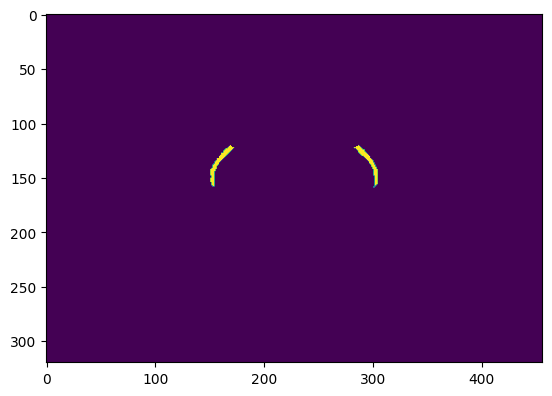

In [45]:
plt.imshow(annotations[150,:,:])

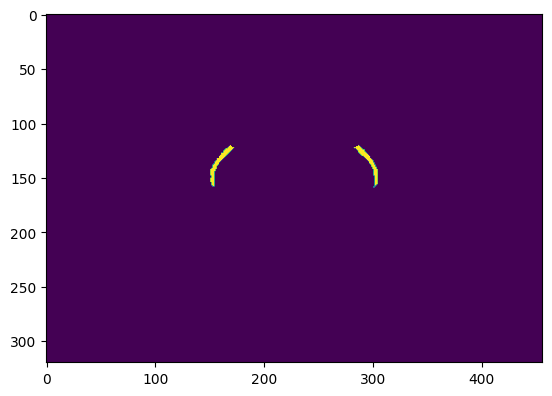

In [49]:
plt.imshow(annotation_saved[150,:,:])

In [47]:
annotations.shape

(528, 320, 456)

In [50]:
vol = np.zeros((528, 456, 320))

idx = 0
for ap in range(0, 528):
    for dv in range(0, 320):
        for ml in range(0, 456):
            vol[ap, ml, dv] = loaded_data[idx]
            idx += 1
            # int idx = 0;
            # for (int ap = 0; ap < apLength; ap++)
            #     for (int dv = 0; dv < dvDepth; dv++)
            #         for (int ml = 0; ml < mlWidth; ml++)
            #         {
            #             atlasTexture.SetPixel(ap, ml, dv, Color.Lerp(Color.black, Color.white, data[idx++]));
            #         }

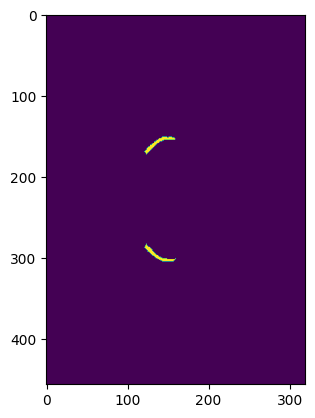

In [51]:
plt.imshow(vol[150,:,:])